In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/multiclassificationtask/sample_submission.csv
/kaggle/input/multiclassificationtask/train.csv
/kaggle/input/multiclassificationtask/test.csv


# Imports and setups

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Loading train dataset

In [3]:
df = pd.read_csv('/kaggle/input/multiclassificationtask/train.csv')
df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,2178.0,D-penicillamine,16374.0,F,N,N,N,N,0.5,263.0,3.20,43.0,1110.0,106.95,67.0,430.0,9.6,3.0,C
1,1,2644.0,D-penicillamine,17774.0,F,N,N,N,N,0.8,280.0,3.60,22.0,678.0,62.00,80.0,427.0,13.0,3.0,C
2,2,3069.0,Placebo,17844.0,F,N,N,N,N,1.1,408.0,4.40,54.0,2108.0,142.60,137.0,203.0,10.6,3.0,C
3,3,2216.0,Placebo,19221.0,F,N,Y,Y,N,0.8,252.0,3.70,36.0,843.0,55.80,56.0,336.0,9.6,4.0,C
4,4,2256.0,Placebo,21600.0,F,N,N,N,N,4.7,348.0,3.06,464.0,961.0,120.90,146.0,298.0,11.0,2.0,D


# Exploratory Data Analysis 

In [4]:
df.shape

(15000, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8494 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8502 non-null   object 
 6   Hepatomegaly   8492 non-null   object 
 7   Spiders        8491 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6701 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8399 non-null   float64
 13  Alk_Phos       8488 non-null   float64
 14  SGOT           8486 non-null   float64
 15  Tryglicerides  6666 non-null   float64
 16  Platelets      14436 non-null  float64
 17  Prothrombin    14984 non-null  float64
 18  Stage 

In [6]:
df.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.000000,15000.000000,15000.000000,6701.000000,15000.000000,8399.000000,8488.000000,8486.000000,6666.000000,14436.000000,14984.000000,15000.000000
mean,7499.500000,1971.721267,19298.658267,1.845433,329.177302,3.526103,75.647339,1618.598233,106.483631,111.387886,252.917983,10.626111,3.024800
std,4330.271354,1333.733576,3797.580260,2.674859,180.320802,0.372268,74.830472,1767.240078,57.206017,55.056133,94.049175,0.731416,0.871303
min,0.000000,3.000000,400.000000,0.200000,120.000000,0.500000,2.000000,3.400000,0.900000,19.000000,32.000000,9.000000,1.000000
25%,3749.750000,1095.000000,16658.000000,0.600000,242.000000,3.290000,31.000000,720.000000,71.000000,80.000000,181.000000,10.100000,2.000000
50%,7499.500000,1786.000000,19544.000000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,248.000000,10.600000,3.000000
75%,11249.250000,2635.000000,22347.000000,1.800000,364.000000,3.770000,89.000000,1664.000000,130.200000,133.000000,311.000000,11.000000,4.000000
max,14999.000000,38320.000000,129398.000000,28.000000,2078.000000,4.640000,662.000000,13862.400000,2653.000000,1669.000000,1024.000000,18.000000,4.000000


In [7]:
df['Age'].isnull().sum()

0

Quyida jadvaldagi datasetdagi ustun nomlari o‘zbek tiliga qisqacha tarjima qilinib, har biriga qisqa tushuntirish berilgan:

1. id - Identifikator: Har bir qator uchun noyob raqam, ma'lumotlarni aniqlash uchun ishlatiladi.
2. N_Days - Kunlar soni: Bemorni kuzatish davomiyligi, kunlarda.
3. Drug - Dori: Bemorga berilgan dori turi.
4. Age - Yosh: Bemorning yoshi.
5. Sex - Jins: Bemorning jinsi (erkak yoki ayol).
6. Ascites - Assit: Qorin bo‘shlig‘ida suyuqlik to‘planishi (jigar kasalligi belgisi).
7. Hepatomegaly - Gepatomegaliya: Jigar kattalashishi.
8. Spiders - O‘rgimchak naqshlari: Teri ostidagi qon tomirlarining o‘rgimchak to‘riga o‘xshash ko‘rinishi.
9. Edema - Shish: Tana a'zolarida (ko‘pincha oyoqlarda) suyuqlik tufayli shish paydo bo‘lishi.
10. Bilirubin - Bilirubin: Qonda bilirubin darajasi, jigar faoliyatini ko‘rsatadi.
11. Cholesterol - Xolesterin: Qondagi xolesterin darajasi.
12. Albumin - Albumin: Qondagi oqsil turi, jigar sog‘lig‘ini ko‘rsatadi.
13. Copper - Mis: Qondagi mis miqdori.
14. Alk_Phos - Alkalin fosfataza: Jigar va suyaklar bilan bog‘liq ferment darajasi.
15. SGOT - SGOT (AST): Jigar fermenti, jigar shikastlanishini ko‘rsatadi.
16. Tryglicerides - Triglitseridlar: Qondagi yog‘ turi, yurak va jigar sog‘lig‘i bilan bog‘liq.
17. Platelets - Trombotsitlar: Qonda trombotsitlar soni, qon ivishi uchun muhim.
18. Prothrombin - Protrombin: Qon ivish vaqtini o‘lchaydigan ko‘rsatkich.
19. Stage - Bosqich: Kasallikning rivojlanish bosqichi.
20. Status - Holati: Bemorni holati (masalan, sog‘lom yoki kasal).

Yuqoridagi malumotlardan ko'rinib turibdiki, Data Cleaning qilish kerak chunki bir nechta ustunlarda missing values mavjud. Bundan tashqari, datasetda ham raqamli ham kategorik ustunlar bor shuning uchun kategorik ustunlarni raqam shakliga aylantirib olish kerak.
Bu jarayonlarning barchasini pipeline orqali amalga oshiramiz.
Age ustuni kunlarda berilgan va buni yilga o'zgartirib olish kerak.

In [8]:
# Datasetni raqamli va kategorik featurlarga bo'lib olamiz
numerical_features = ['N_Days','Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
                      'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
                        'Edema', ]

# Data Visualisation

**Traget visualisation**

<function matplotlib.pyplot.show(close=None, block=None)>

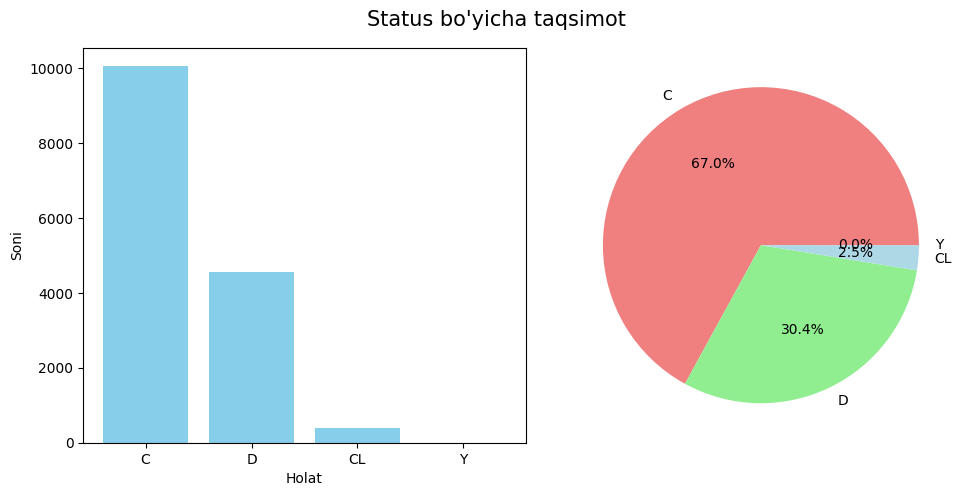

In [9]:
classes = df['Status'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# 1-grafik: Bar plot
ax[0].bar(classes.index, classes.values, color='skyblue')
ax[0].set_xlabel("Holat")
ax[0].set_ylabel("Soni")

# 2-grafik: Pie chart
ax[1].pie(classes.values, labels=classes.index, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen', 'lightblue'])
 

fig.suptitle("Status bo'yicha taqsimot", fontsize=15)
plt.tight_layout(pad=1)
plt.show

D (Died - Vafot etgan)

C (Censored - Davom etayotgan, ya'ni kuzatuvda)

CL (Censored due to Liver Transplant - Jigar transplantatsiyasi tufayli kuzatuv to‘xtatilgan)

Birinchi grafik (Bar): Bu grafikda Status ustunidagi har bir holat (D, C, CL) bo‘yicha bemorlar soni ko‘rsatilgan. Masalan, agar D=4500 bo‘lsa, bu 4500 bemor vafot etganini bildiradi.

Ikkinchi grafik (Pie): Bu grafikda har bir holatning foizdagi ulushi ko‘rsatilgan. Masalan, C=10,000 bo‘lsa va umumiy 15,000 bemor bo‘lsa, bu taxminan 67.0% ni tashkil qiladi.

Grafiklarda korish mumkin, "Y" qo'shimcha class qo'shilib qolgan, buni ustundan o'chirib yuboramiz.

In [10]:
df = df[df['Status'] != 'Y']

**Numerical Feature Visualizations**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


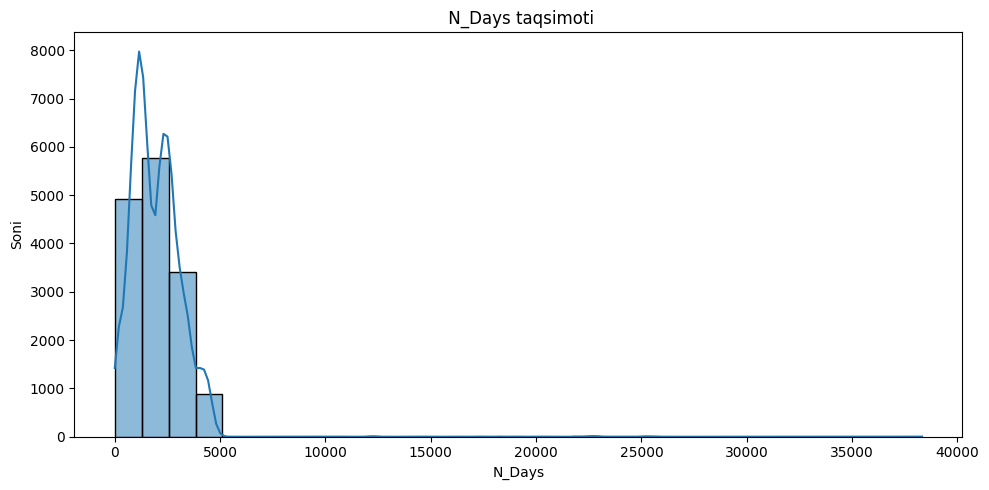

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


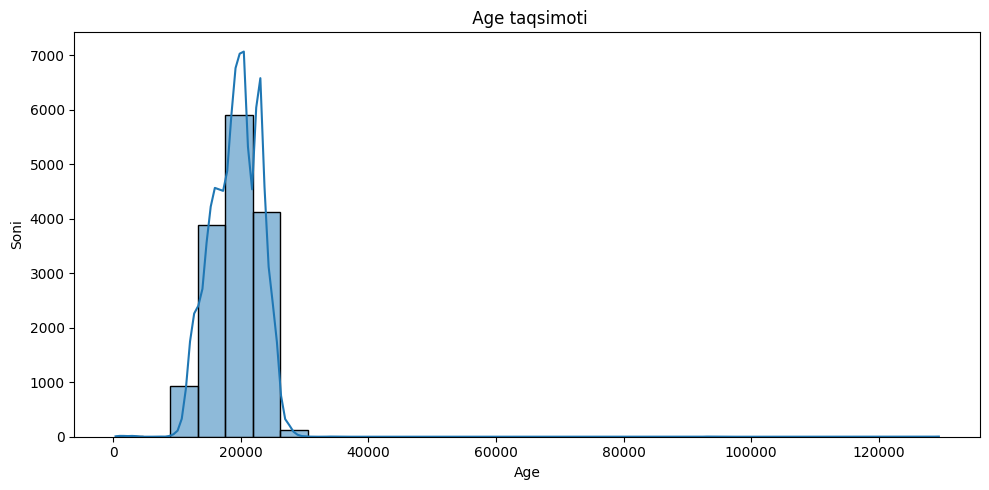

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


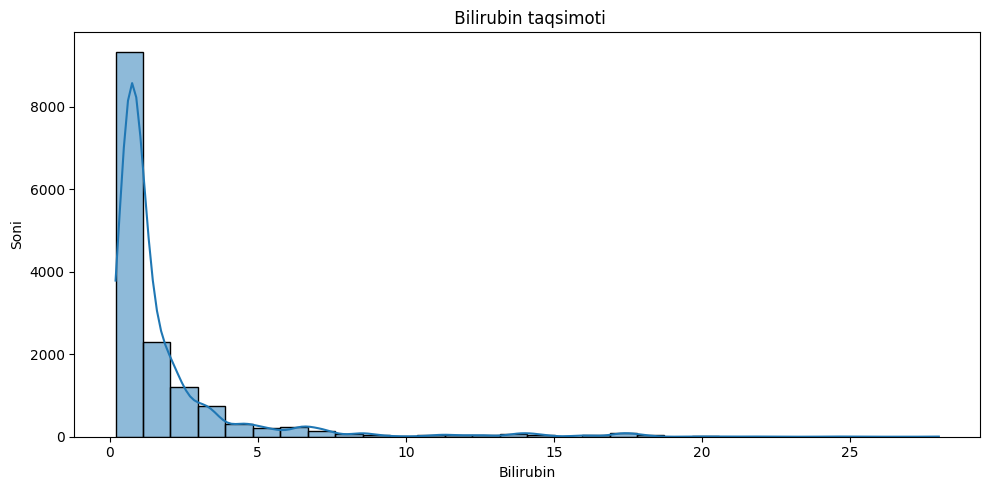

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


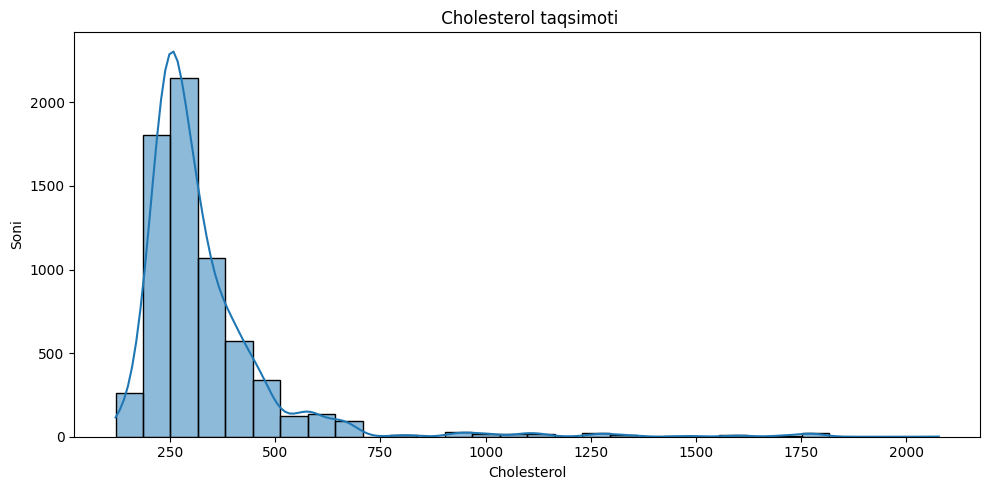

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


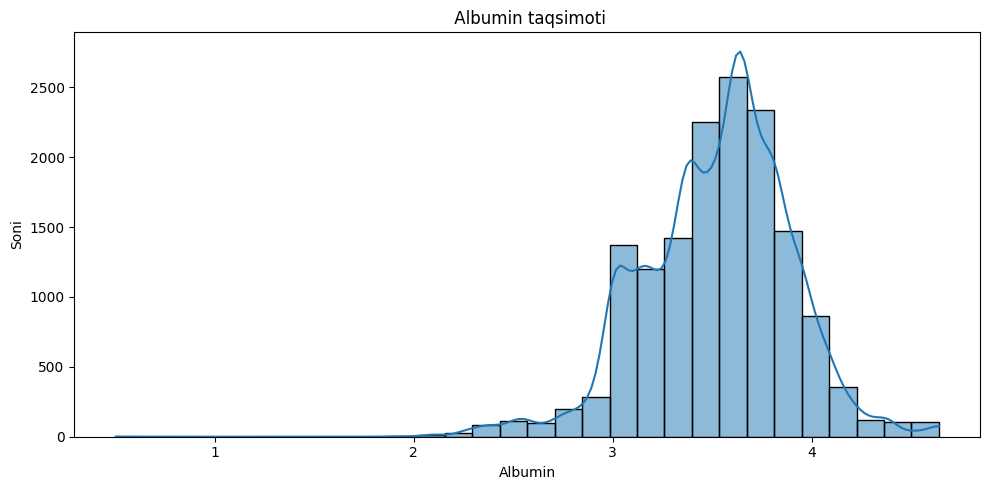

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


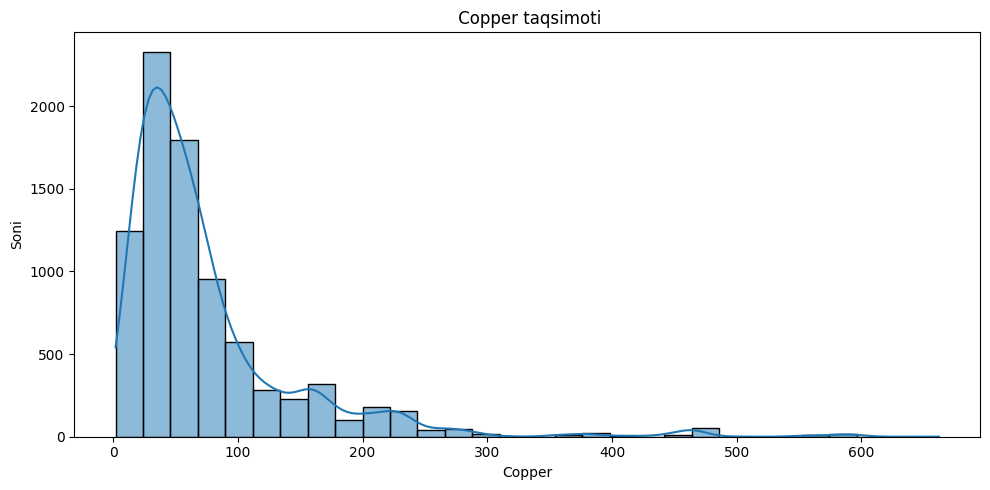

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


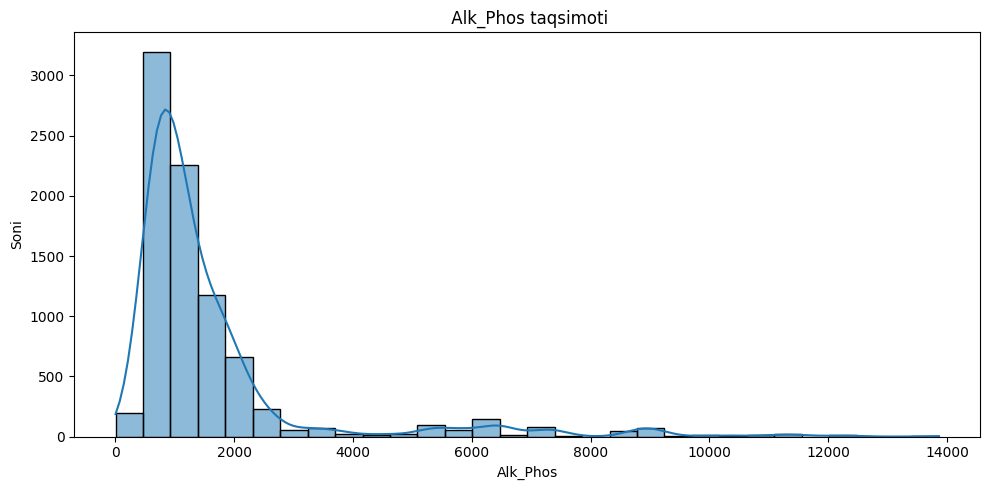

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


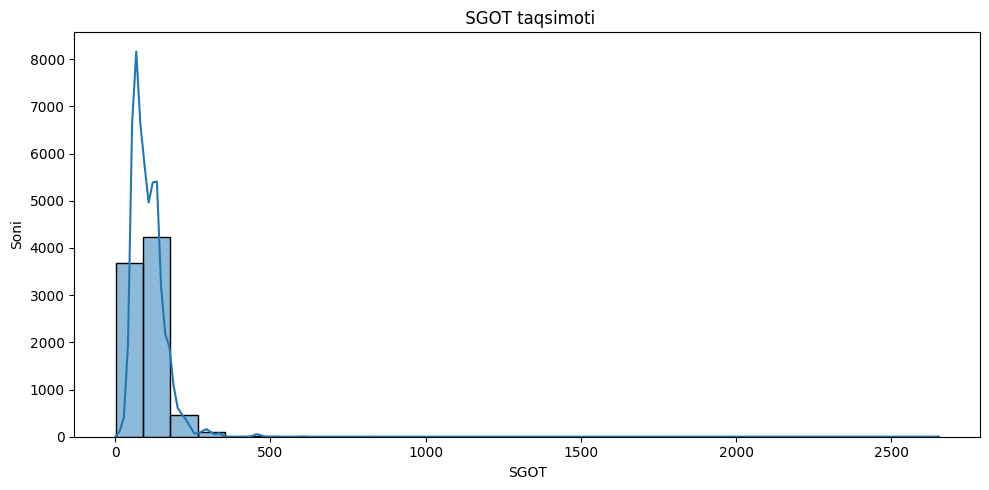

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


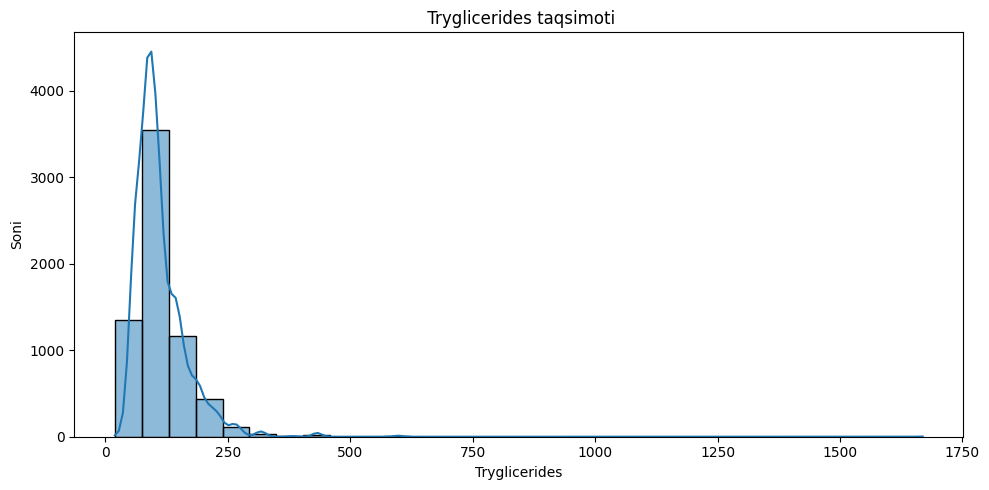

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


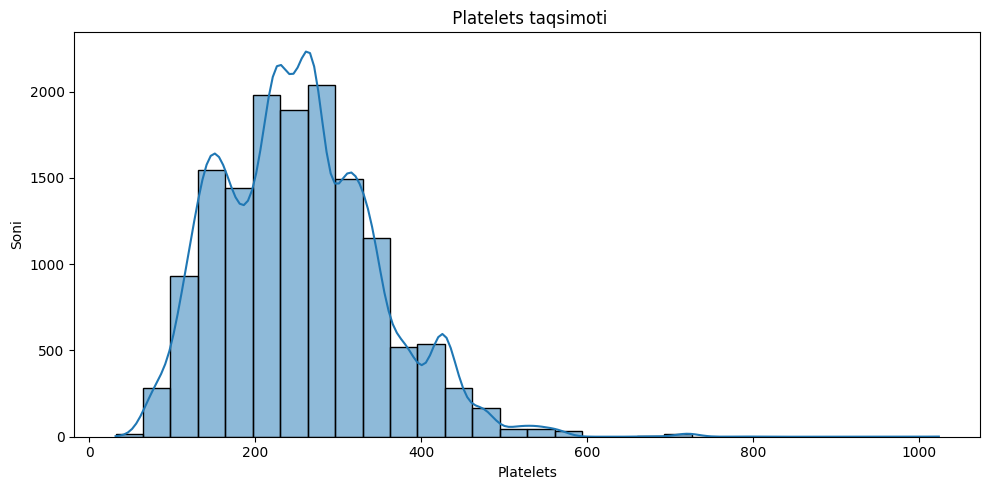

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


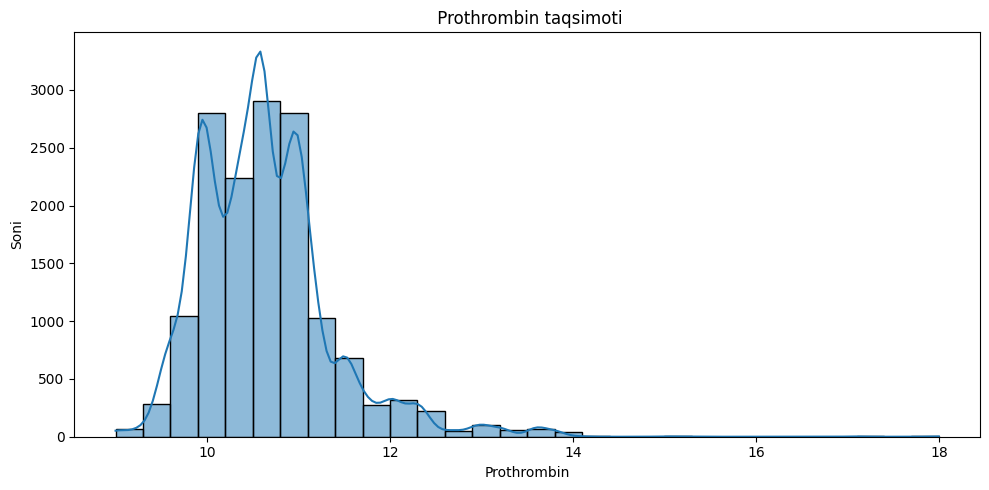

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


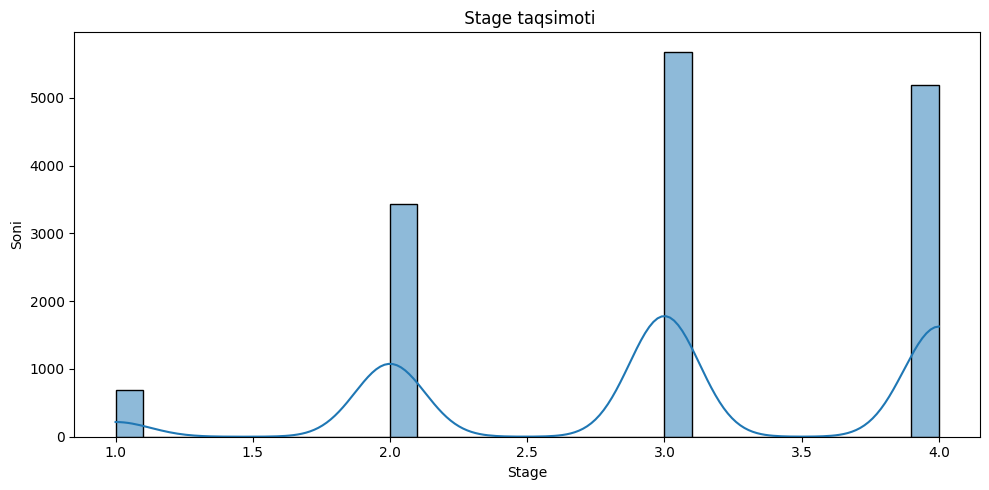

In [11]:
for column in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=column, bins=30, kde=True)
    plt.xlabel(column)
    plt.ylabel('Soni')
    plt.title(f' {column} taqsimoti')
    plt.tight_layout()
    plt.show()
    

**Categorical Feature Visualization**

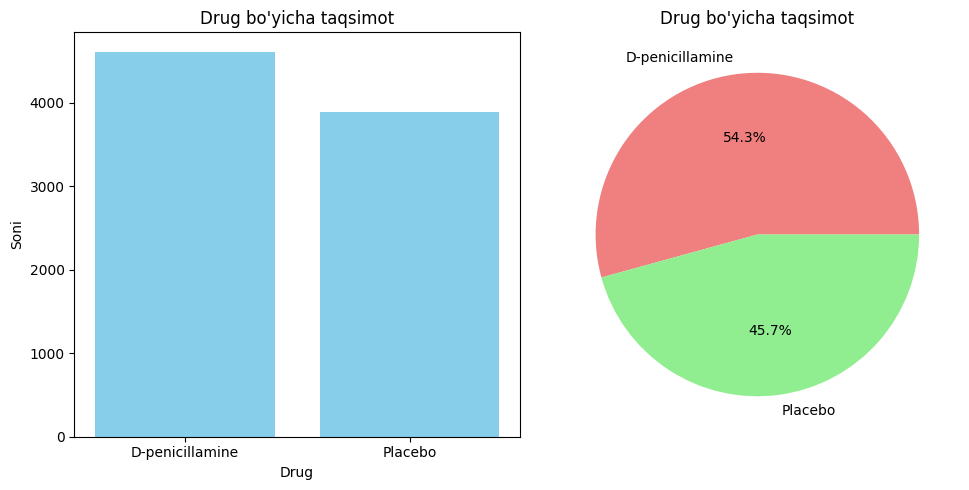

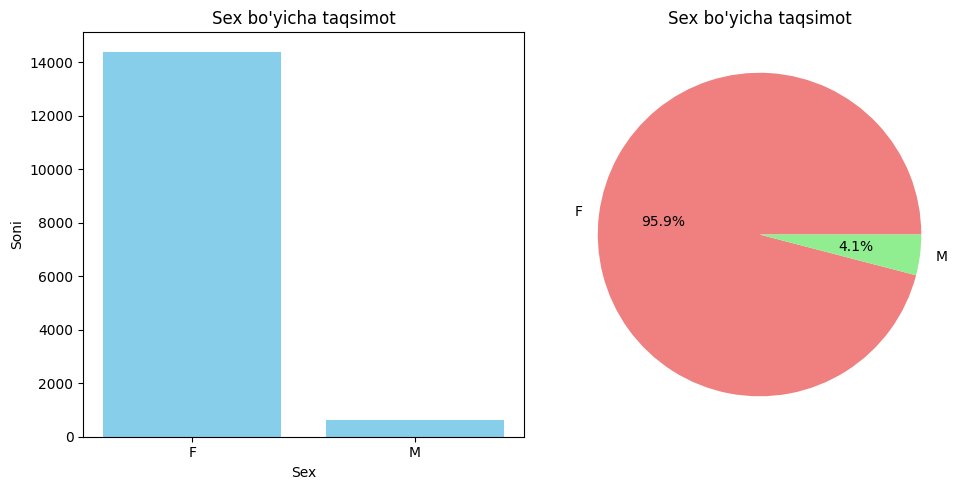

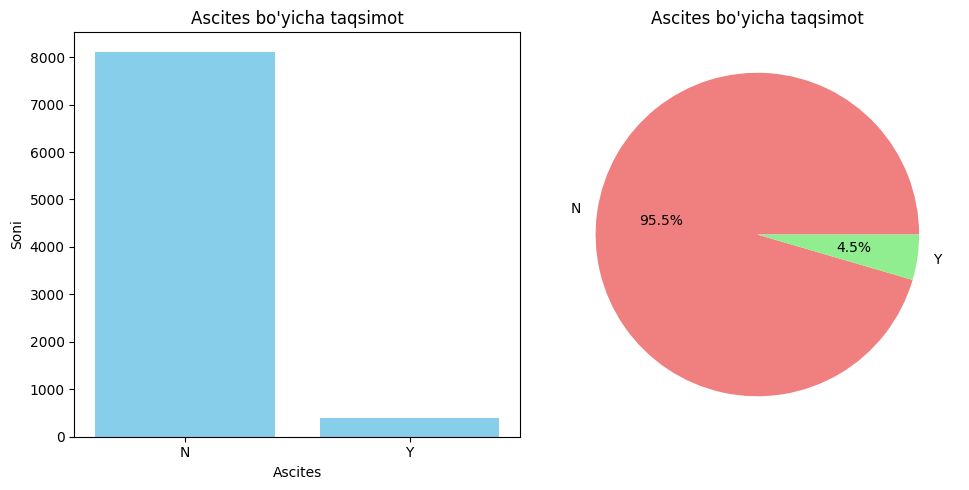

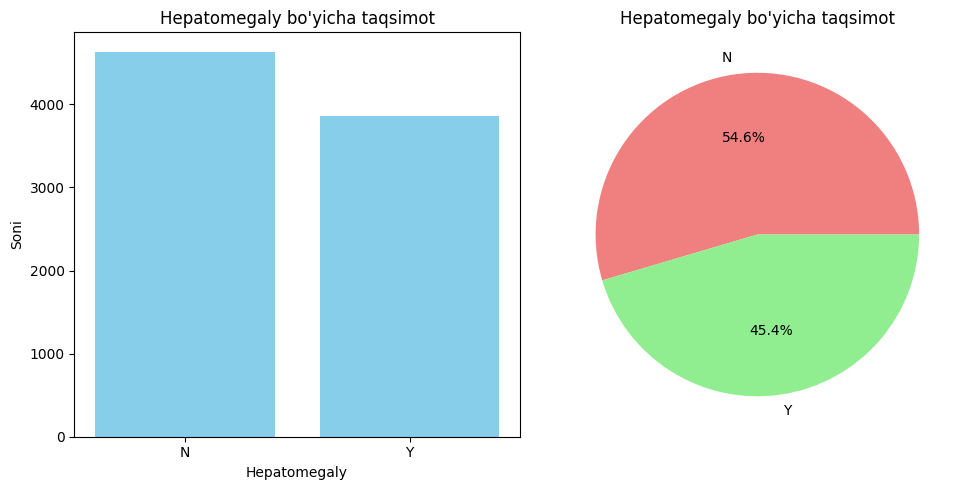

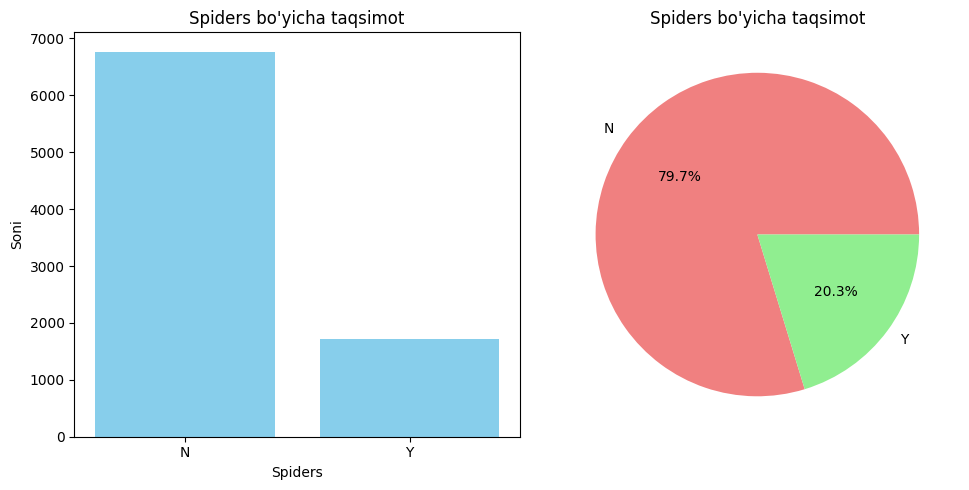

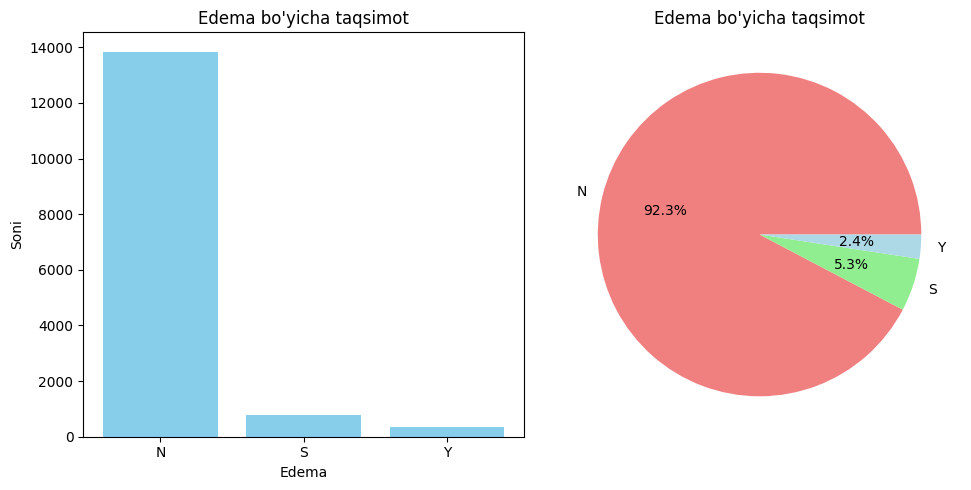

In [12]:
for col in categorical_features:
    counts = df[col].value_counts()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Barchart
    ax[0].bar(counts.index, counts.values, color='skyblue')
    ax[0].set_title(f"{col} bo'yicha taqsimot")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Soni")

    # Pie chart
    ax[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen', 'lightblue', 'lightyellow'])
    ax[1].set_title(f"{col} bo'yicha taqsimot")

    plt.tight_layout()
    plt.show

# **Data Preprocessing**

In [13]:
df['Status'].value_counts()

Status
C     10053
D      4565
CL      381
Name: count, dtype: int64

In [14]:
# Status ustunini encode qilamiz
# Map status 0-D, 1-C, 2-CL
df['Status'] = df['Status'].map({'D':0, 'C':1, 'CL':2})

In [15]:
df['Status'].value_counts()

Status
1    10053
0     4565
2      381
Name: count, dtype: int64

**Pipeline yaratib olamiz**

In [16]:
# sonli ustunlar uchun
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# kategorik ustunar uchun
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

**ColumnTransformer**


In [17]:
preprocessor = ColumnTransformer([
    ('numerical', num_pipeline, numerical_features),
    ('categorical', cat_pipeline, categorical_features)
])

In [18]:
# Feature va target qismlarga bo'lib olamiz
X = df.drop('Status', axis=1)
y = df['Status']

In [19]:
X['Age'] = X['Age']//365
X

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,2178.0,D-penicillamine,44.0,F,N,N,N,N,0.5,263.0,3.20,43.0,1110.0,106.95,67.0,430.0,9.6,3.0
1,1,2644.0,D-penicillamine,48.0,F,N,N,N,N,0.8,280.0,3.60,22.0,678.0,62.00,80.0,427.0,13.0,3.0
2,2,3069.0,Placebo,48.0,F,N,N,N,N,1.1,408.0,4.40,54.0,2108.0,142.60,137.0,203.0,10.6,3.0
3,3,2216.0,Placebo,52.0,F,N,Y,Y,N,0.8,252.0,3.70,36.0,843.0,55.80,56.0,336.0,9.6,4.0
4,4,2256.0,Placebo,59.0,F,N,N,N,N,4.7,348.0,3.06,464.0,961.0,120.90,146.0,298.0,11.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,1783.0,Placebo,63.0,F,N,Y,N,S,1.3,243.0,3.76,58.0,944.0,97.00,93.0,233.0,9.9,4.0
14996,14996,3492.0,NaN,36.0,F,NaN,NaN,NaN,N,0.7,NaN,4.03,NaN,NaN,NaN,NaN,273.0,10.3,2.0
14997,14997,1170.0,NaN,62.0,F,NaN,NaN,NaN,N,0.8,NaN,3.14,NaN,NaN,NaN,NaN,280.0,10.6,3.0
14998,14998,1433.0,Placebo,59.0,F,N,N,N,N,0.6,280.0,4.04,52.0,843.0,28.38,189.0,334.0,10.0,2.0


In [20]:
# train va test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [22]:
X_test_processed.shape

(3000, 25)

# Machine Learning

In [23]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1.0)
}

results = {}
# Klasslar ro'yxatini aniqlash
all_classes = np.unique(np.concatenate((y_train, y_test))) 

for name, model in models.items():
    print(f"Model: {name}")
    # Modelni o'rgatish
    model.fit(X_train_processed, y_train)
 
    #predict qilamiz
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)
    if y_pred_proba.shape[1] == 2:
        y_pred_proba = y_pred_proba[:, 1] 
    else:
    
        pass

   # Clip qilish
    y_pred_proba_clipped = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)

    # logloss hisoblash
    logloss = log_loss(y_test, y_pred_proba_clipped, labels=all_classes)
    # accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Logloss: {logloss:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    results[name] = {
        'Accuracy': acc,
        'Logloss': logloss
    }
 

Model: Decision Tree
Accuracy: 0.7820
Logloss: 7.5295

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       922
           1       0.85      0.84      0.85      2004
           2       0.16      0.19      0.18        74

    accuracy                           0.78      3000
   macro avg       0.57      0.58      0.57      3000
weighted avg       0.79      0.78      0.78      3000

Model: Random Forest
Accuracy: 0.8483
Logloss: 0.4898

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       922
           1       0.86      0.94      0.90      2004
           2       0.80      0.05      0.10        74

    accuracy                           0.85      3000
   macro avg       0.83      0.57      0.59      3000
weighted avg       0.85      0.85      0.84      3000

Model: Gradient Boosting
Accuracy: 0.8503
Logloss: 0.3787

Classification Report:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:23:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8530
Logloss: 0.3950

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.78       922
           1       0.87      0.93      0.90      2004
           2       0.65      0.23      0.34        74

    accuracy                           0.85      3000
   macro avg       0.78      0.63      0.67      3000
weighted avg       0.85      0.85      0.85      3000



In [24]:
y_pred_proba_clipped

array([[1.33566782e-01, 8.66025269e-01, 4.08017833e-04],
       [1.42217968e-02, 9.83699858e-01, 2.07829732e-03],
       [2.03856140e-01, 7.85814762e-01, 1.03290435e-02],
       ...,
       [7.62048876e-03, 9.88022804e-01, 4.35669441e-03],
       [1.14638343e-01, 8.70113373e-01, 1.52483201e-02],
       [6.33949637e-02, 9.34987009e-01, 1.61801418e-03]], dtype=float32)

In [25]:
# Eng yaxshi modelni log loss boyicha tanlash
best_model_name = min(results.items(), key=lambda x: x[1]['Logloss'])[0]
best_model = models[best_model_name]
print(f"\n Eng yaxshi model (LogLoss boyicha): {best_model_name} (LogLoss: {results[best_model_name]['Logloss']:.4f})")


 Eng yaxshi model (LogLoss boyicha): Gradient Boosting (LogLoss: 0.3787)


# Submission


In [26]:
test_df = pd.read_csv('/kaggle/input/multiclassificationtask/test.csv')
test_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,22646.0,NaN,22646.0,F,NaN,NaN,NaN,N,1.4,NaN,3.34,NaN,NaN,NaN,NaN,190.0,11.0,4.0
1,15001,2149.0,NaN,18993.0,F,NaN,NaN,NaN,N,0.9,NaN,3.24,NaN,NaN,NaN,NaN,233.0,9.0,2.0
2,15002,3850.0,D-penicillamine,16050.0,M,N,N,N,N,1.0,460.0,3.64,75.0,2148.0,102.3,118.0,172.0,10.6,3.0
3,15003,2419.0,D-penicillamine,20354.0,F,N,N,N,N,0.6,258.0,3.96,31.0,642.0,70.0,83.0,336.0,10.8,2.0
4,15004,1086.0,NaN,23376.0,F,NaN,NaN,NaN,N,4.4,NaN,4.40,NaN,NaN,NaN,NaN,447.0,10.3,2.0


In [27]:
test_df.shape

(10000, 19)

In [28]:
test_df.isnull().sum()

id                  0
N_Days              0
Drug             4398
Age                 0
Sex                 0
Ascites          4391
Hepatomegaly     4402
Spiders          4404
Edema               0
Bilirubin           0
Cholesterol      5647
Albumin             0
Copper           4469
Alk_Phos         4403
SGOT             4406
Tryglicerides    5680
Platelets         382
Prothrombin         9
Stage               0
dtype: int64

In [29]:
test_df['Age'] = test_df['Age']//365
test_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,22646.0,NaN,62.0,F,NaN,NaN,NaN,N,1.4,NaN,3.34,NaN,NaN,NaN,NaN,190.0,11.0,4.0
1,15001,2149.0,NaN,52.0,F,NaN,NaN,NaN,N,0.9,NaN,3.24,NaN,NaN,NaN,NaN,233.0,9.0,2.0
2,15002,3850.0,D-penicillamine,43.0,M,N,N,N,N,1.0,460.0,3.64,75.0,2148.0,102.30,118.0,172.0,10.6,3.0
3,15003,2419.0,D-penicillamine,55.0,F,N,N,N,N,0.6,258.0,3.96,31.0,642.0,70.00,83.0,336.0,10.8,2.0
4,15004,1086.0,NaN,64.0,F,NaN,NaN,NaN,N,4.4,NaN,4.40,NaN,NaN,NaN,NaN,447.0,10.3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,2106.0,Placebo,45.0,F,N,N,N,N,1.1,1128.0,3.35,91.0,815.0,127.10,166.0,421.0,9.6,1.0
9996,24996,186.0,D-penicillamine,35.0,M,N,Y,N,N,0.6,267.0,3.02,225.0,728.0,120.90,90.0,142.0,12.3,4.0
9997,24997,3458.0,D-penicillamine,55.0,F,N,N,N,N,0.9,NaN,3.35,136.0,1995.0,128.00,NaN,243.0,10.6,2.0
9998,24998,2891.0,D-penicillamine,55.0,F,N,N,N,N,0.8,NaN,3.75,63.0,674.0,26.35,NaN,325.0,10.0,1.0


In [30]:
# Yuqorida yaratib olgan pipeline orqali test setni ham transform qilib olamiz
test_processed = preprocessor.transform(test_df)

In [31]:
# predict qilamiz
y_test_bashorat = best_model.predict(test_processed)
y_test_bashorat_proba = best_model.predict_proba(test_processed)

# Ehtimolliklarni [1e-15, 1-1e-15] oralig‘ida chegaralash
y_test_bashorat_proba_clipp = np.clip(y_test_bashorat_proba, 1e-15, 1 - 1e-15)

In [32]:
y_test_bashorat_proba.shape

(10000, 3)

In [33]:
y_test_bashorat_proba_clipp

array([[0.84738525, 0.14846411, 0.00415064],
       [0.05905002, 0.9351335 , 0.00581648],
       [0.22133976, 0.74485926, 0.03380098],
       ...,
       [0.13434964, 0.85662792, 0.00902243],
       [0.04114364, 0.95514459, 0.00371177],
       [0.22651187, 0.71596647, 0.05752166]])

In [34]:
ids = test_df['id']
ids

0       15000
1       15001
2       15002
3       15003
4       15004
        ...  
9995    24995
9996    24996
9997    24997
9998    24998
9999    24999
Name: id, Length: 10000, dtype: int64

In [35]:
model.classes_

array([0, 1, 2])

In [36]:
print(len(ids))
print(y_test_bashorat_proba_clipp.shape)

10000
(10000, 3)


In [37]:
submission = pd.DataFrame({
    'id':ids,
    'Status_C':y_test_bashorat_proba_clipp[:,1],
    'Status_CL':y_test_bashorat_proba_clipp[:,2],
    'Status_D':y_test_bashorat_proba_clipp[:,0]
})
submission

,id,Status_C,Status_CL,Status_D
0,15000,0.148464,0.004151,0.847385
1,15001,0.935133,0.005816,0.059050
2,15002,0.744859,0.033801,0.221340
3,15003,0.974533,0.002116,0.023351
4,15004,0.392542,0.174578,0.432880
...,...,...,...,...
9995,24995,0.882216,0.059885,0.057898
9996,24996,0.118587,0.043947,0.837467
9997,24997,0.856628,0.009022,0.134350
9998,24998,0.955145,0.003712,0.041144


In [38]:
#'D':0, 'C':1, 'CL':2}
# CSV faylga saqlash
submission.to_csv('submission.csv', index=False)
print("Submission fayli tayyor: submission.csv")

Submission fayli tayyor: submission.csv
